In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [83]:
train = pd.read_csv('Train.csv', index_col = "uniqueid")
test = pd.read_csv('Test.csv', index_col = "uniqueid")

In [3]:
train.head()

,country,year,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
uniqueid,,,,,,,,,,,,
uniqueid_1,Kenya,2018,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
uniqueid_2,Kenya,2018,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
uniqueid_3,Kenya,2018,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
uniqueid_4,Kenya,2018,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
uniqueid_5,Kenya,2018,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23524 entries, uniqueid_1 to uniqueid_2117
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   bank_account            23524 non-null  object
 3   location_type           23524 non-null  object
 4   cellphone_access        23524 non-null  object
 5   household_size          23524 non-null  int64 
 6   age_of_respondent       23524 non-null  int64 
 7   gender_of_respondent    23524 non-null  object
 8   relationship_with_head  23524 non-null  object
 9   marital_status          23524 non-null  object
 10  education_level         23524 non-null  object
 11  job_type                23524 non-null  object
dtypes: int64(3), object(9)
memory usage: 2.3+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10086 entries, uniqueid_6056 to uniqueid_3002
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 10086 non-null  object
 1   year                    10086 non-null  int64 
 2   location_type           10086 non-null  object
 3   cellphone_access        10086 non-null  object
 4   household_size          10086 non-null  int64 
 5   age_of_respondent       10086 non-null  int64 
 6   gender_of_respondent    10086 non-null  object
 7   relationship_with_head  10086 non-null  object
 8   marital_status          10086 non-null  object
 9   education_level         10086 non-null  object
 10  job_type                10086 non-null  object
dtypes: int64(3), object(8)
memory usage: 945.6+ KB


In [6]:
train.describe()

,year,household_size,age_of_respondent
count,23524.000000,23524.000000,23524.000000
mean,2016.975939,3.797483,38.805220
std,0.847371,2.227613,16.520569
min,2016.000000,1.000000,16.000000
25%,2016.000000,2.000000,26.000000
50%,2017.000000,3.000000,35.000000
75%,2018.000000,5.000000,49.000000
max,2018.000000,21.000000,100.000000


In [7]:
train.isnull().sum().sum()

0

In [8]:
test.isnull().sum().sum()

0

In [9]:
train.shape

(23524, 12)

In [10]:
test.shape

(10086, 11)

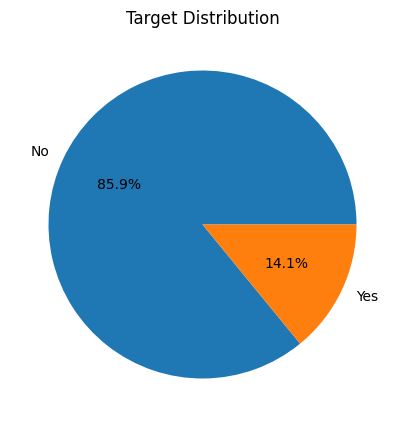

In [11]:
target_count = train['bank_account'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(target_count, labels=target_count.index, autopct='%1.1f%%')
plt.title('Target Distribution')
plt.show()


In [84]:
numerical_columns = ['household_size', 'age_of_respondent']

for col in numerical_columns:
  train[col] = pd.to_numeric(train[col])
  test[col] = pd.to_numeric(test[col])

In [85]:
categorical_columns = ['country','location_type', 'location_type', 'cellphone_access', 'gender_of_respondent', 'relationship_with_head', 'marital_status', 'education_level', 'job_type']

for col in categorical_columns:
  train[col] = train[col].astype('category')
  test[col] = test[col].astype('category')

In [86]:
target = train['bank_account']
train = train.drop('bank_account', axis=1)

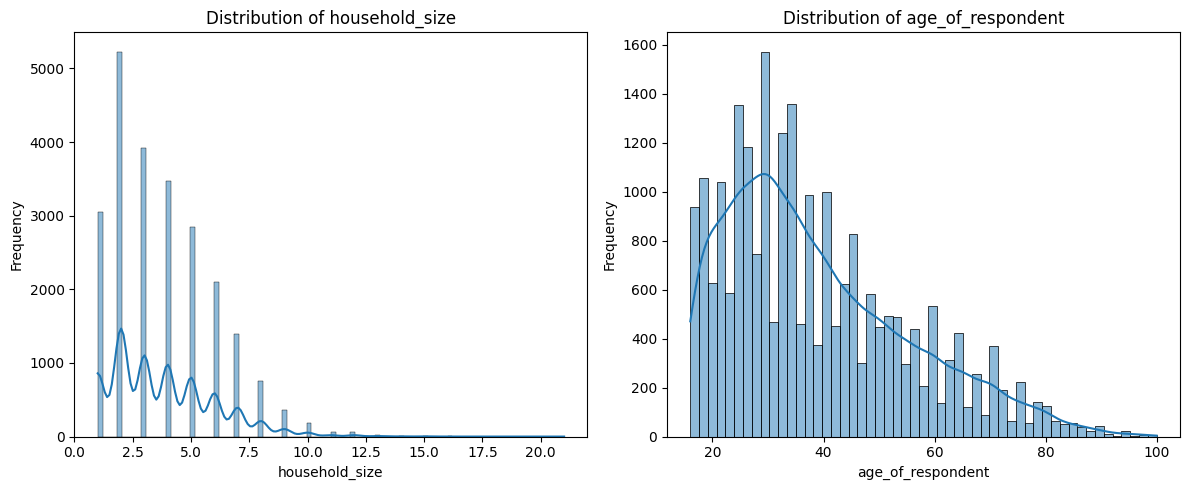

In [15]:
fig, axes = plt.subplots(1, len(numerical_columns), figsize=(12, 5))

# Iterate through numerical columns and plot histograms
for i, col in enumerate(numerical_columns):
    sns.histplot(data=train[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

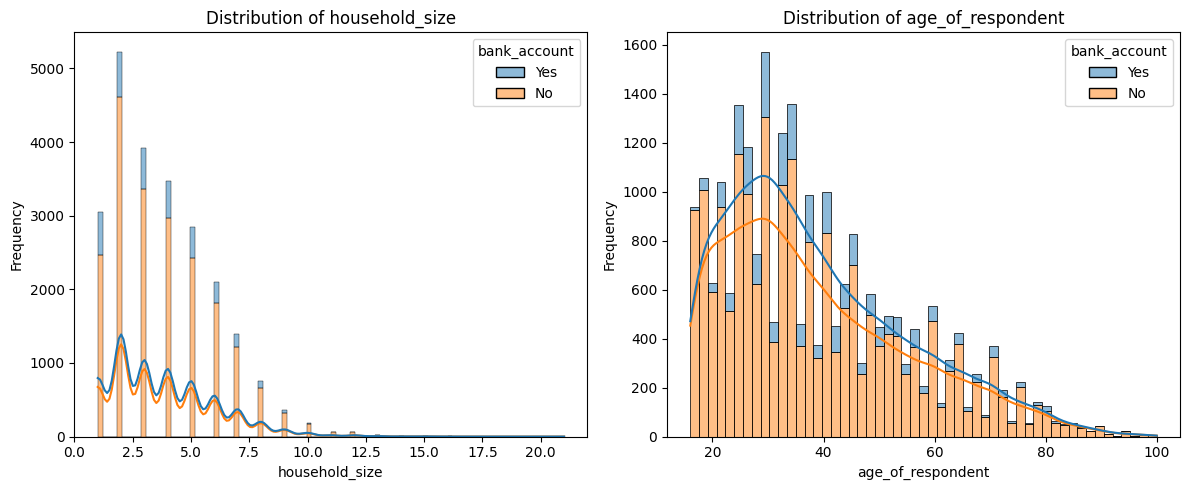

In [16]:
fig, axes = plt.subplots(1, len(numerical_columns), figsize=(12, 5))

# Iterate through numerical columns and plot histograms
for i, col in enumerate(numerical_columns):
    sns.histplot(data=train, x=col, hue=target, kde=True, ax=axes[i], multiple='stack')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

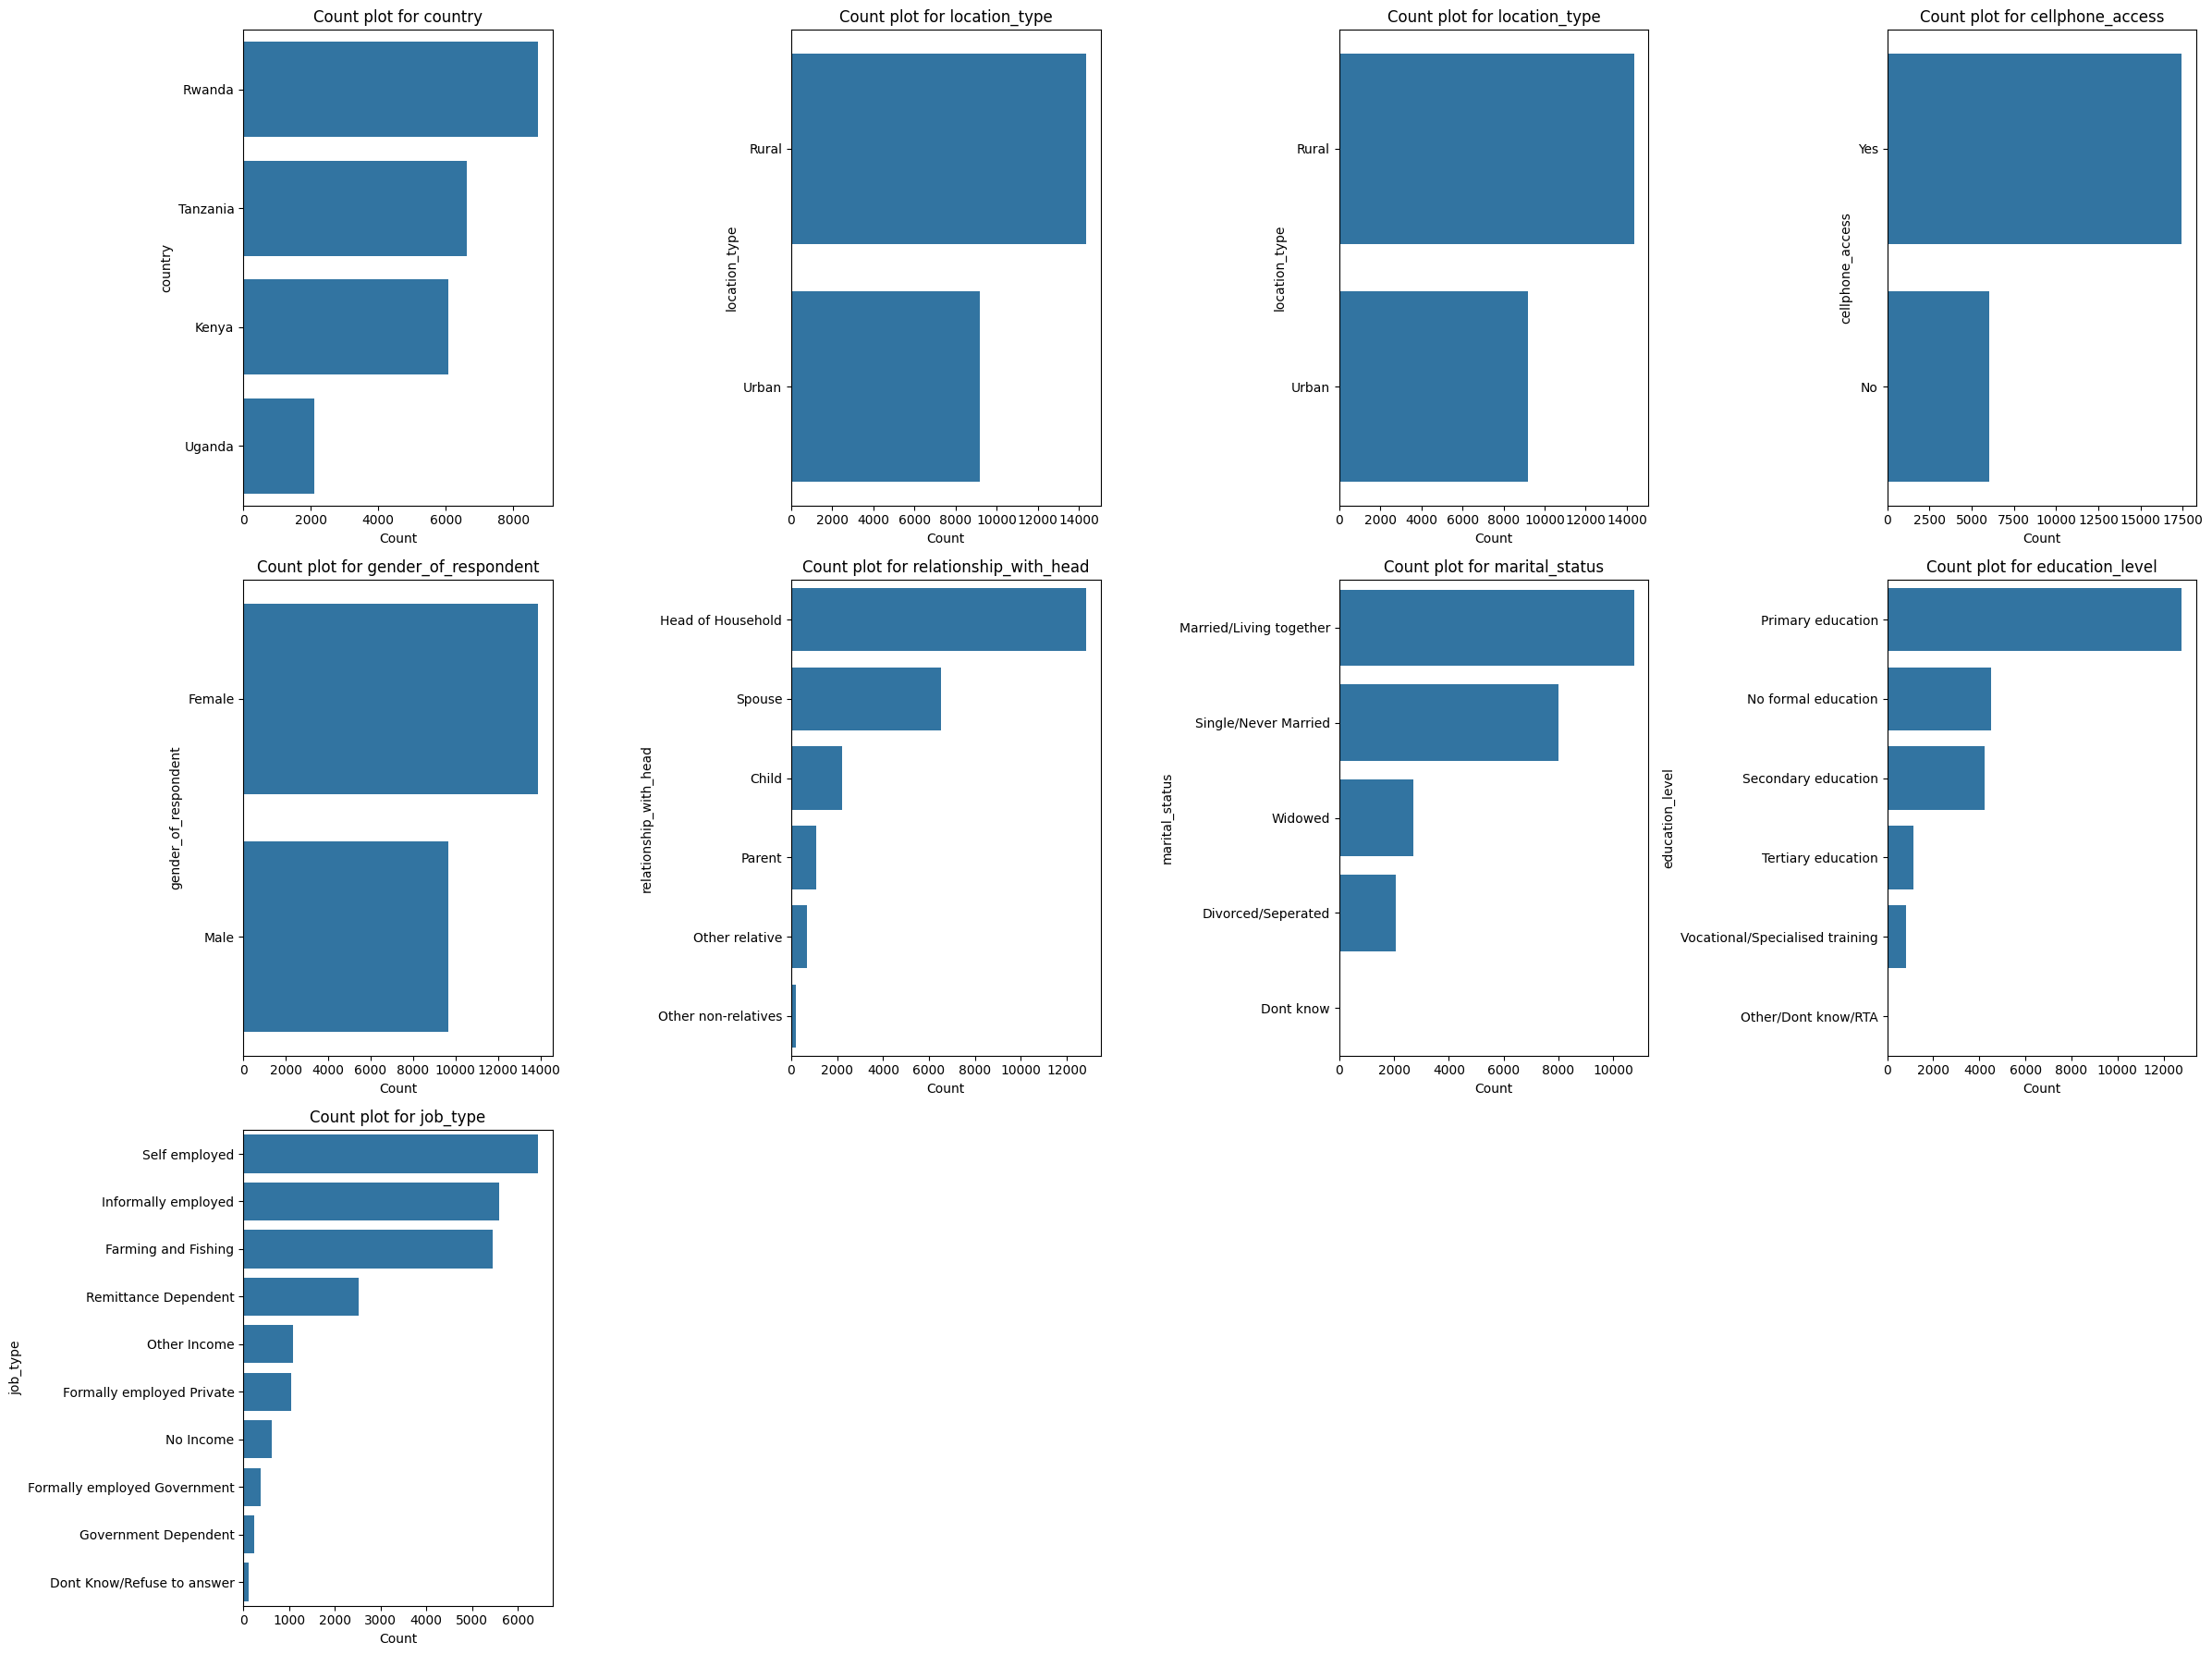

In [17]:
n_cols = int(len(categorical_columns) ** 0.5) + 1  # Calculate square root and add 1 for safety
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols  # Ceiling division to ensure enough rows

# Create subplots dynamically
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows))

# Flatten the axes array
axes = axes.flatten()

# Loop through each categorical column and create a count plot
for i, col in enumerate(categorical_columns):
    sns.countplot(y=col, data=train, order=train[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Count plot for {col}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel(col)

# Hide any empty subplots
for j in range(len(categorical_columns), n_rows * n_cols):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

In [87]:
train['year'] = pd.to_datetime(train['year'])
train['year'] = train['year'].dt.year

test['year'] = pd.to_datetime(test['year'])
test['year'] = test['year'].dt.year

In [19]:
train.head()

,country,year,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
uniqueid,,,,,,,,,,,
uniqueid_1,Kenya,1970,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
uniqueid_2,Kenya,1970,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
uniqueid_3,Kenya,1970,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
uniqueid_4,Kenya,1970,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
uniqueid_5,Kenya,1970,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


it is important to note the imbalance of the target varaible

In [88]:
label_encoder = LabelEncoder()

target = label_encoder.fit_transform(target)

In [89]:
X_train, X_val, y_train, y_val = train_test_split(train, target, test_size=0.2, random_state=42)

In [90]:
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

In [100]:
param_grid = {
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_data_in_leaf': [10, 20, 30],
    'feature_fraction': [0.8, 0.9, 1.0],
    'bagging_fraction': [0.8, 0.9, 1.0],
    'bagging_freq': [0, 5, 10]
}

# Create the LightGBM classifier
lgb_clf = lgb.LGBMClassifier(objective='binary', metric='binary_logloss')

# Perform grid search
grid_search = GridSearchCV(estimator=lgb_clf, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train, categorical_feature=categorical_columns)

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 1780, number of negative: 10766
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not 

In [91]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 15,
    'min_data_in_leaf': 30,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 0,
    'is_unbalance': True,
}

num_boost_round = 100

model = lgb.train(params, train_data, num_boost_round, valid_sets=[val_data], callbacks=[lgb.early_stopping(stopping_rounds=10)])


[LightGBM] [Info] Number of positive: 2670, number of negative: 16149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 143
[LightGBM] [Info] Number of data points in the train set: 18819, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.141878 -> initscore=-1.799780
[LightGBM] [Info] Start training from score -1.799780
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.36181


In [37]:
y_pred = model.predict(X_val, num_iteration=model.best_iteration)

In [26]:
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"RMSE: {rmse}")

RMSE: 0.32426950092767265


In [38]:
y_pred_class = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_val, y_pred_class)

print(f"Accuracy: {accuracy}")

Accuracy: 0.8635494155154091


In [99]:
xgb_y_pred = model.predict(test)

# Define a threshold for binary classification
threshold = 0.5

# Check if the output is 1D or 2D and convert to binary outcomes accordingly
if xgb_y_pred.ndim == 1:  # If the output is 1D
    xgb_y_pred = (xgb_y_pred >= threshold).astype(int)
else:  # Expected 2D output
    xgb_y_pred = (xgb_y_pred[:, 1] >= threshold).astype(int)


submission = pd.DataFrame({
  "uniqueid": test.index.astype(str) + " x " + test["country"].astype(str),
  "bank_account": xgb_y_pred
})
submission.to_csv('xgb_submission.csv', index=False)